- competition/dataset : [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- date : 2021/01/21
- original : [https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

## Titnaic Top 4% with ensemble modeling

**✏ 필사 1회** 

### 목차
**1. Intro**  
**2. Load and check data**  
ㅤ2-1. 데이터 로딩  
ㅤ2-2. 이상값 탐지  
ㅤ2-3. 트레이닝 셋과 테스트 셋 결합  
ㅤ2-4. 결측값 확인  

**3. Feature analysis**  
ㅤ3-1. 숫자형 변수  
ㅤ3-2. 범주형 변수  

**4. Filling missing Values**  
ㅤ4-1. Age  

**5. Feature engineering**  
ㅤ5-1. Name/Title  
ㅤ5-2. Family Size  
ㅤ5-3. Cabin  
ㅤ5-4. Ticket  

**6. Modeling**  
ㅤ6-1. 간단한 모델링  
ㅤㅤㅤ6-1-1. 교차 검증 모델  
ㅤㅤㅤ6-1-2. 최적 모델을 위한 하이퍼 파라미터 튜닝  
ㅤㅤㅤ6-1-3. 학습 곡선  
ㅤㅤㅤ6-1-4. 트리 기반 분류기의 변수 중요도  
ㅤ6-2. 앙상블 모델링  
ㅤㅤㅤ6-2-1. 모델 결합  
ㅤ6-3. 예측  
ㅤㅤㅤ6-3-1. 예측 및 결과 제출

### 1. Introduction
몇 가지 feature 분석을 보인 뒤 feature engineering에 초점을 맞출 것입니다. 마지막 파트에서는 voting 방법을 사용하여 타이타닉의 생존여부를 모델링하고 예측하는 것을 다룰 예정입니다.  

이 노트북은 크게 세 가지 파트로 나뉩니다.  
* Feature analysis
* Feature engineering
* Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

### 2. Load and check data

#### 2-1. 데이터 로딩

In [2]:
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')
IDtest = test['PassengerId']

#### 2-2. 이상값 탐지

In [3]:
def detect_outliers(df, n, features):
    '''
    Tukey 방법에 따라 feature의 df를 사용하고, 이상값을 n개 이상 포함하는 관측값들을 리턴
    '''
    outlier_indices = []
    
    for col in features:
        # 1사분위수(25%)
        Q1 = np.percentile(df[col], 25)
        # 3사분위수(75%)
        Q3 = np.percentile(df[col], 75)
        # IQR(사분범위)
        IQR = Q3 - Q1
        
        # 이상치 기준
        outlier_step = 1.5 * IQR
        
        # feature의 col에 대한 이상치 인덱스 리스트 결정
        outlier_list_col = df[(df[col] < Q1-outlier_step)|(df[col] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

In [4]:
outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

이상값들은 예측에 큰 영향을 주기 때문에 이들을 관리하기 위해 인덱스 리스트를 만들었습니다.  

이상값 검출을 위해 Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값들의 1분위수와 3분위수 사이에 구성된 범위를 정의(IQR)하였습니다.  

숫자형 변수들의 이상값을 탐지하고, 두 개 이상의 이상값을 갖는 행을 이상값이라고 판단했습니다.

In [5]:
train.iloc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상값이 탐지되었습니다. 28, 89, 342번 승객은 Fare 값이 크고, 나머지 7명은 SibSp 값이 매우 큽니다.

In [6]:
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

#### 2-3. 트레이닝 셋과 테스트 셋 결합

In [7]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

이후에 feature engineering에서 범주형 변수로 바꾸는 과정에 동일한 수의 feature를 얻기 위해 트레이닝 셋과 테스트 셋을 병합했습니다.

#### 2-4. 결측값 확인

In [8]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin feature는 결측값 부분에서 매우 중요하며, Survived의 결측값은 테스트 셋의 결합에 의한 것입니다.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [12]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### 3. Feature analysis

#### 3-1. 숫자형 변수

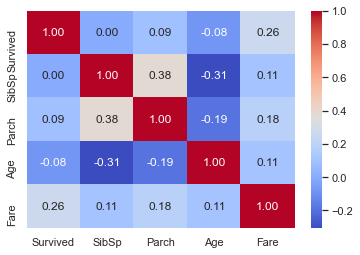

In [14]:
# 숫자형 변수(SibSp, Parch, Age, Fare)와 Survived 간의 상관행렬
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Fare feature만이 생존 가능성과 유의미한 관계가 있는 것으로 보입니다. 그렇다고 다른 feature들이 쓸모없는 것은 아닙니다. 이 feature들의 하위 모집단이 생존과 관계가 있을 수 있습니다. 이것을 판단하기 위해, 해당 feature들을 더 자세히 분석해볼 필요가 있습니다.

##### SibSp

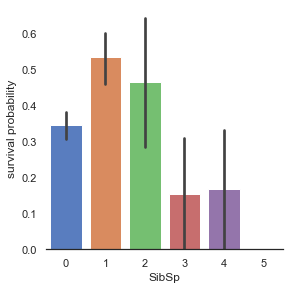

In [15]:
g = sns.factorplot('SibSp', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

승객들에게 형제자매나 배우자의 수가 많을수록 생존 가능성이 낮아지는 것처럼 보입니다. 혼자 탑승했거나 1~2명과 함께 탑승한 사람이 생존 가능성을 더 많이 가집니다.  

해당 관찰 내용 매우 흥미롭습니다. feature engineering 파트에서 이 카테고리들을 설명하는 새로운 feature를 고려해볼 수 있습니다.

##### Parch

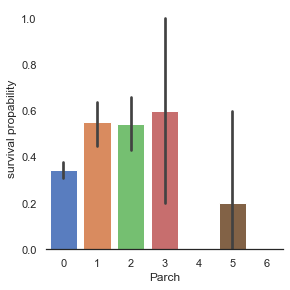

In [16]:
g = sns.factorplot('Parch', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival propability')

혼자 탑승하거나(Parch=0) 중간 규모 이상의 가족(Parch=3~6)보다 작은 규모의 가족들의 생존 가능성이 더 많습니다.  

부모/자식의 수가 3명 이상인 탑승자의 표준편차가 중요하므로 주의해야 합니다.

##### Age

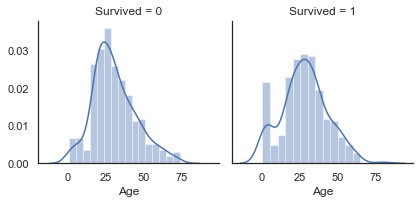

In [17]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

Age의 분포는 꼬리가 있는 분포이며, 가우시안 분포로 보입니다.  

생존한 경우와 생존하지 못한 경우의 연령 분포가 다르다는 것을 알 수 있습니다. Survived = 1의 그래프에서 젊은 승객들과 일치하는 피크가 있습니다. 또한 60-80세의 승객들의 생존류은 낮다는 사실 또한 알 수 있습니다.  

따라서 Age가 Survived와 관계가 없더라도 생존 가능성이 더 높거나 낮은 연령대가 있음을 알 수 있습니다.  

매우 어린 연령대의 승객들의 생존 가능성은 높습니다.

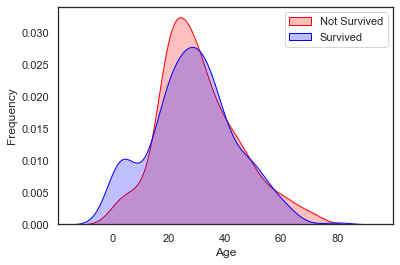

In [18]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1)&(train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 밀도 함수를 겹쳐서 살펴모녀 0~5세 영유아 나이대에 피크가 있음을 명확하게 확인할 수 있습니다.

##### Fare

In [19]:
dataset['Fare'].isnull().sum()

1

In [20]:
# 결측값은 중간값으로 대체
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

결측값이 하나밖에 없으므로 예측에 영향을 미치지 않도록 중간값으로 대체했습니다.

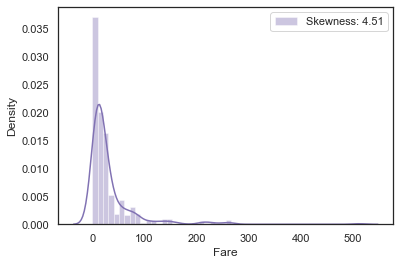

In [21]:
# Fare 분포
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

Fare의 분포는 매우 비대칭입니다. 비대칭도를 줄이기 위해 log 함수를 취해주는 것이 좋습니다.

In [22]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

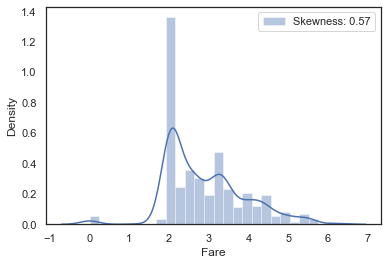

In [23]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

#### 3-2. 범주형 변수

##### Sex

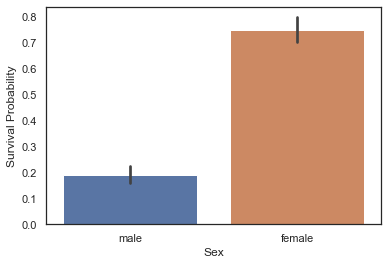

In [24]:
g = sns.barplot('Sex', 'Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [25]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


##### Pclass

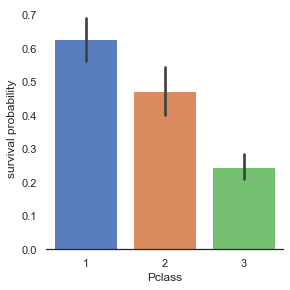

In [26]:
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

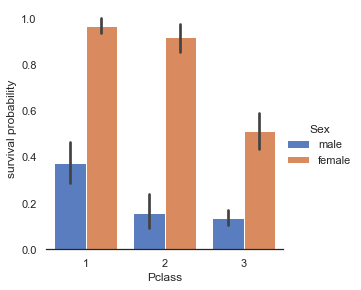

In [27]:
g = sns.factorplot('Pclass', 'Survived', hue='Sex', data=train, size=4, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

생존률은 세 클래스에서 같지 않습니다. 1등석 승객들은 2, 3등석보다 생존 가능성이 더 많았습니다. 이러한 경향은 남녀 승객을 함께 볼 때 유효합니다.

##### Embarked

In [28]:
dataset['Embarked'].isnull().sum()

2

In [29]:
dataset['Embarked'].fillna('S', inplace=True)

결측값 두 개는 가장 많은 값인 'S'로 대체합니다.

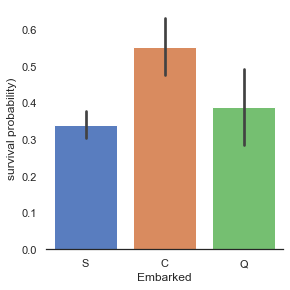

In [30]:
g = sns.factorplot('Embarked', 'Survived', data=train, size=4, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability)')

C (Cherbourg) 항구에서 온 승객들의 생존률이 높습니다. 여기서 1등석 승객의 비율이 S (Southampton)와 Q (Queenstown)보다 Cherbourg에서 더 높을 것이라는 가설을 세워보겠습니다.  

Pclass의 분포와 Embarked를 비교해봅시다.

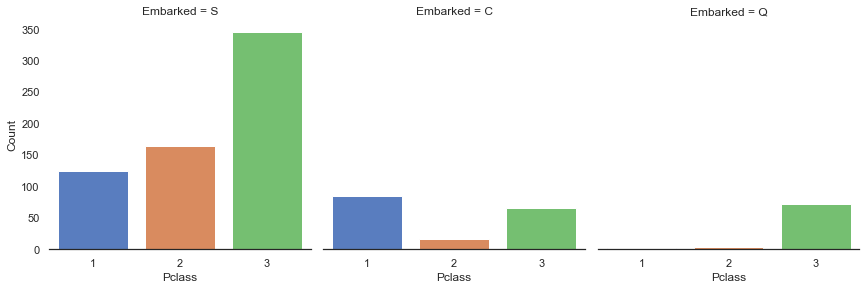

In [31]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=4, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

3등석은 Southampton과 Queenstown에서 탑승한 승객이 많은 반면, Cherbourg 승객들은 대부분 생존률이 높은 1등석입니다.  

1등석의 생존률이 왜 높을까요? 1등석 승객들은 대피하는 동안 우선 순위였다고 가정해봅니다.

### 4. Filling missing Values

#### 4-1. Age
위에서 봤듯이 dataset의 Age 컬럼에는 256개의 결측값이 존재합니다. 어린이와 같이 생존률이 높은 하위집단이 존재하므로 Age feature는 유지하고, 결측값을 채우는 것이 더 좋습니다.  

이 문제를 해결하기 위해 Sex, Parch, Pclass, SipSp와 같은 관련있는 feature들을 살펴보겠습니다.

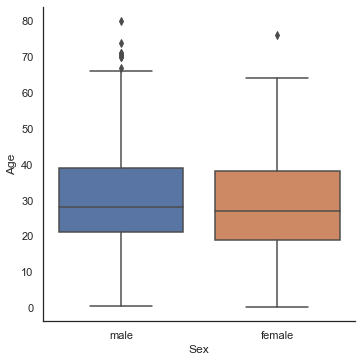

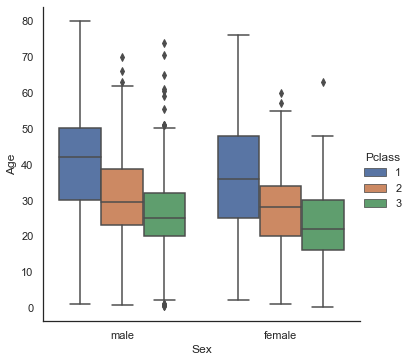

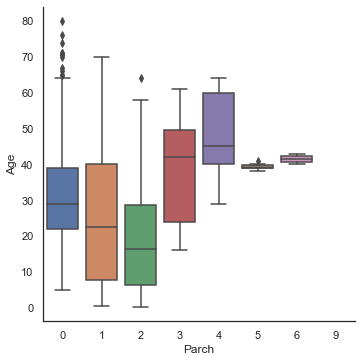

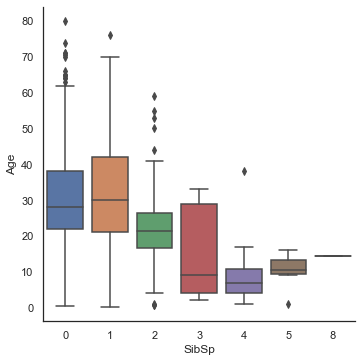

In [32]:
g = sns.factorplot('Sex', 'Age', data=dataset, kind='box')
g = sns.factorplot('Sex', 'Age', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot('Parch', 'Age', data=dataset, kind='box')
g = sns.factorplot('SibSp', 'Age', data=dataset, kind='box')

남성과 여성 하위집단에 대해 연령 분포는 비슷해보이므로 Sex는 Age를 예측하는데 유의한 정보는 아닙니다.  

그러나 Pclass가 높아질수록 나이도 많아집니다.  

게다가 부모/자식의 수가 많을수록 나이가 많고, 형제자매/배우자의 수가 많을수록 나이가 적습니다.

In [33]:
# Sex를 범주형 값으로 변환
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

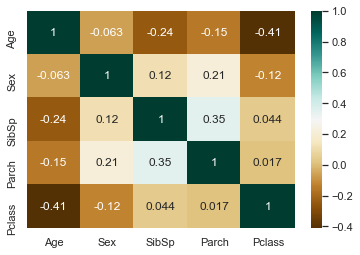

In [34]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

Age는 Sex와는 관계가 없고, Pclass, Parch, SibSp와는 음의 상관관계를 가집니다. 따라서 Age의 결측값을 채우기 위해 SibSp, Parch, Pclass를 사용해봅시다. Pclass, Parch, SibSp에 따라 유사한 행의 중간값으로 결측값을 대체해보겠습니다.

In [35]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp'])&
                               (dataset['Parch'] == dataset.iloc[i]['Parch'])&
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

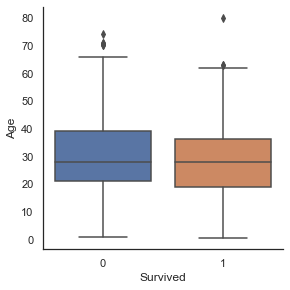

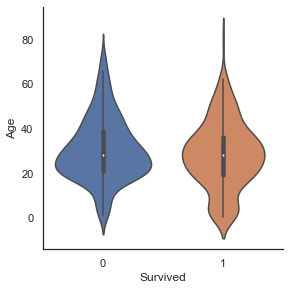

In [36]:
g = sns.factorplot('Survived', 'Age', data=train, kind='box', size=4)
g = sns.factorplot('Survived', 'Age', data=train, kind='violin', size=4)

생존한 하위집단과 생존하지 못한 하위집단의 Age에 대한 중간값은 차이가 없습니다.  

그러나 생존한 승객에 대한 violin plot을 보면, 매우 어린 승객들의 생존률이 높은 것을 다시 확인할 수 있습니다.

### 5. Feature Engineering

#### 5-1. Name/Title

In [37]:
dataset['Name'].head(3)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
Name: Name, dtype: object

Name feature는 승객의 title을 포함하고 있습니다. 대피 과정에서 승객의 title이 영향이 있을 수 있기 때문에, 해당 부분을 고려해보겠습니다.

In [38]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head(3)

0      Mr
1     Mrs
2    Miss
Name: Title, dtype: object

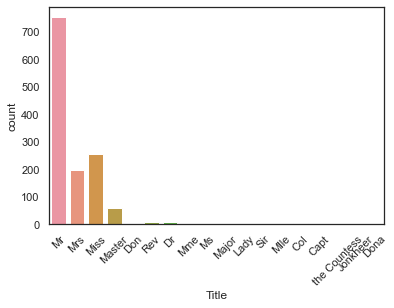

In [39]:
g = sns.countplot('Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

17가지의 title이 있으며, 대부분 수가 적으므로 크게 4개로 묶을 수 있습니다.

In [40]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

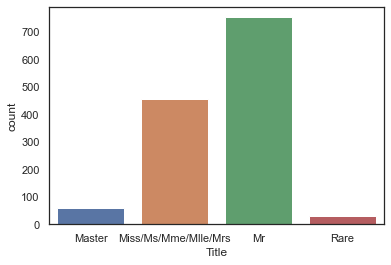

In [41]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

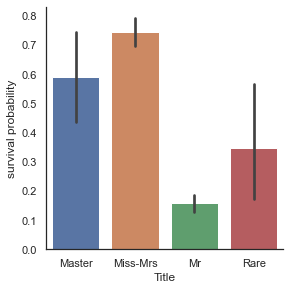

In [42]:
g = sns.factorplot('Title', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"여성과 아이 먼저"  
희귀한 title을 가진 승객의 생존 가능성이 높다는 점이 흥미롭습니다.

In [43]:
# Name 변수 제거
dataset.drop('Name', axis=1, inplace=True)

#### 5-2 Fsize (Family Size)
대가족은 대피 과정에서 형제자매/부모를 찾느라 대피하기에 더 어렵다고 짐작할 수 있습니다. 그래서 SibSp와 Parch, 자기 자신을 더한 Fsize (Family Size) feature을 만들어 볼 수 있습니다.

In [44]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

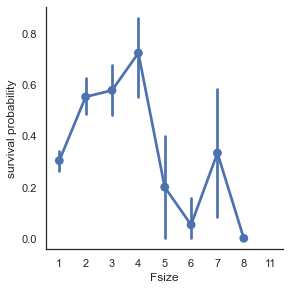

In [45]:
g = sns.factorplot('Fsize', 'Survived', data=dataset, size=4)
g = g.set_ylabels('survival probability')

가족 규모 또한 중요한 역할로 보이고, 대가족의 생존 가능성이 가장 낮습니다.  

가족 규모 또한 4개의 범주로 나눠보겠습니다.

In [46]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

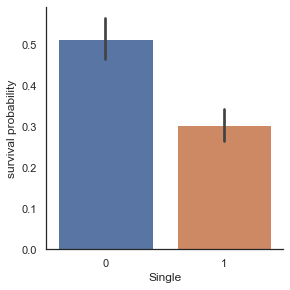

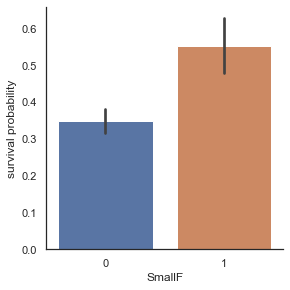

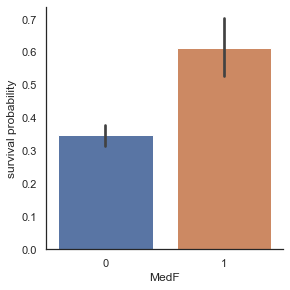

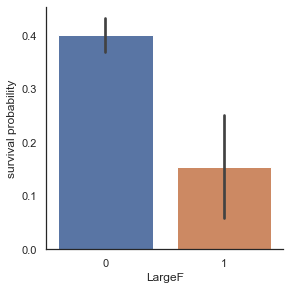

In [47]:
g = sns.factorplot('Single', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

g = sns.factorplot('SmallF', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

g = sns.factorplot('MedF', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

g = sns.factorplot('LargeF', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

factor plot을 통해 혼자 탑승했거나 대규모 가족보다 소규모, 중간규모의 가족에게 생존 기회가 더 많았음을 확인할 수 있습니다.

In [48]:
# 범주형 변수 one-hot encoding
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [49]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [50]:
len(dataset.columns)

22

이제 22개의 feature가 있습니다.

#### 5-3. Cabin

In [51]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [52]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [53]:
dataset['Cabin'].isnull().sum()

1007

Cabin feature는 292개의 값과 1007개의 결측값이 있습니다. 객실이 없는 승객들의 경우 객실 번호 대신 결측값을 입력하는 것으로 알고 있습니다.

In [54]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [55]:
# 객실 번호를 타입으로 변경, 결측값은 X 입력
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

In [56]:
dataset['Cabin'].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

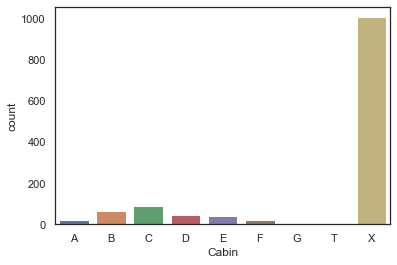

In [57]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

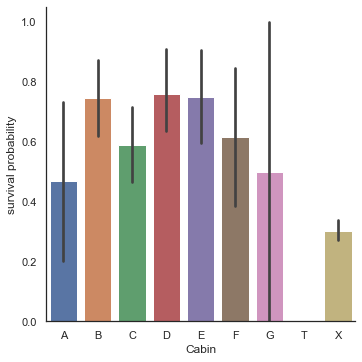

In [58]:
g = sns.factorplot('Cabin', 'Survived', data=dataset, kind='bar', order=['A', 'B', 'C','D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('survival probability')

객실을 가진 승객이 많지 않기 때문에, 생존 가능성은 중요한 표준 편차를 가집니다. 객실 간에는 생존 가능성을 구별할 수 없지만 객실이 있는 승객이 없는 승객보다 생존 가능성이 더 높습니다. 특히 B, C, D, E, F 객실은 더욱 그렇습니다.

In [59]:
dataset = pd.get_dummies(dataset, columns=['Cabin'])

In [60]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

In [61]:
len(dataset.columns)

30

#### 5-4. Ticket

In [62]:
dataset['Ticket'].head(3)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
Name: Ticket, dtype: object

앞부분에 같은 접두사가 붙은 티켓은 같은 공간에 있는 객실을 예약했음을 의미합니다. 같은 접두사를 가진 티켓은 클래스와 생존률이 비슷할 것입니다.  

Ticket feature의 접두사만 사용하겠습니다.

In [63]:
Ticket = []
for i in list(dataset['Ticket']):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head(3)

0        A5
1        PC
2    STONO2
Name: Ticket, dtype: object

In [64]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [65]:
# Pclass one-hot encoding
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [66]:
# 불필요한 변수 제거
dataset.drop('PassengerId', axis=1, inplace=True)

In [67]:
dataset.head(3)

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1


### 6. Modeling

In [68]:
# 트레이닝 셋과 테스트 셋 분류
train = dataset[:train_len]
test = dataset[train_len:]
test.drop('Survived', axis=1, inplace=True)

In [72]:
# train feature와 label 구분
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
x_train = train.drop('Survived', axis=1)

#### 6-1. 간단한 모델링

##### 6-1-1. 교차 검증 모델  
stratified Kfold 교차 검증을 통해 10개의 유명한 분류기에 대해 각각의 평균 정확도를 비교해봅시다.  

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron (neural network) (다층신경망)
* KNN
* Logistic Regression (로지스틱회귀분석)
* Linear Discriminant Analysis (선형판별분석)

In [90]:
# Kfold stratified 교차 검증
kfold = StratifiedKFold(n_splits=10)

In [88]:
classifiers = [
    SVC(random_state=123),
    DecisionTreeClassifier(random_state=123),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=123), random_state=123, learning_rate=0.1),
    RandomForestClassifier(random_state=123),
    ExtraTreesClassifier(random_state=123),
    GradientBoostingClassifier(random_state=123),
    MLPClassifier(random_state=123),
    KNeighborsClassifier(),
    LogisticRegression(random_state=123),
    LinearDiscriminantAnalysis()
]

In [91]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, x_train, y_train, scoring='accuracy', cv=kfold, n_jobs=4))

In [92]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [93]:
cv_res = pd.DataFrame({
    'CrossValMeans':cv_means,
    'CrossValerrors':cv_std,
    'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron',
                'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']
})

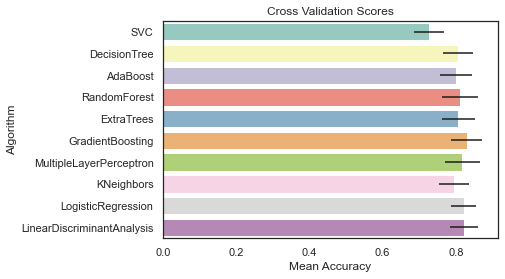

In [95]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

앙상블 모델에는 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 사용해보려 합니다.

##### 6-1-2. 최적 모델을 위한 하이퍼 파라미터 튜닝
AdaBoost, ExtraTrees, RandomForest, GradientBoosting, SVC 분류기에 대한 격자 탐색 최적화를 수행했습니다.  

저는 cpu가 4개이기 때문에 n_jobs를 4로 설정하였습니다. n_jobs 값이 크면 연산 속도가 매우 줄어듭니다. 그러나 다음 과정은 매우 오래 걸릴 것입니다. 4개의 cpu로도 15분이 소요되었습니다.  

*verbose:  
0 = silent  
1 = progress bar  
2 = one line per epoch  

In [112]:
# AdaBoost 사용
adaDTC = AdaBoostClassifier(DecisionTreeClassifier(), random_state=5)
ada_param_grid = {
    'base_estimator__criterion':['gini', 'entropy'],
    'base_estimator__splitter':['best', 'random'],
    'n_estimators':[1, 2],
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(x_train, y_train)
ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_score_)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.1s


0.8218590398365679


[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    3.2s finished


In [113]:
#ExtraTress 사용
ExtC = ExtraTreesClassifier()
ex_param_grid = {
    'max_depth':[None],
    'max_features':[1, 3, 10],
    'min_samples_split':[2, 3, 10],
    'min_samples_leaf':[1, 3, 10],
    'bootstrap':[False],
    'n_estimators':[100, 300],
    'criterion':['gini']
}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy',n_jobs=4, verbose=1)
gsExtC.fit(x_train, y_train)
ExtC_best = gsExtC.best_estimator_
print(gsExtC.best_score_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.7s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   56.0s finished


0.8342951991828397


In [117]:
# RandomForest 사용
RFC = RandomForestClassifier()
rf_param_grid = {
    'max_depth':[None],
    'max_features':[1, 3, 10],
    'min_samples_split':[2, 3, 10],
    'min_samples_leaf':[1, 3, 10],
    'bootstrap':[False],
    'n_estimators':[100, 300],
    'criterion':['gini']
}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(x_train, y_train)
RFC_best = gsRFC.best_estimator_
print(gsRFC.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


0.8308988764044944


In [105]:
# GradientBoosting 사용
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss':['deviance'],
    'n_estimators':[100, 200, 300],
    'learning_rate':[0.1, 0.05, 0.01],
    'max_depth':[4, 8],
    'min_samples_leaf':[100, 150],
    'max_features':[0.3, 0.1]
}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(x_train, y_train)
GBC_best = gsGBC.best_estimator_
print(gsGBC.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   33.1s finished


0.8308861082737486


In [106]:
### SVC 사용
SVMC = SVC(probability=True)
svc_param_grid = {
    'kernel':['rbf'],
    'gamma':[0.001, 0.01, 0.1, 1],
    'C':[1, 10, 50, 100, 200, 300, 1000]
}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(x_train, y_train)
SVMC_best = gsSVMC.best_estimator_
print(gsSVMC.best_score_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   33.4s finished


0.8331332992849847


##### 6-1-3. 학습 곡선
학습 곡선은 트레이닝 셋에 대한 과적합과 트레이닝 크기가 정확도에 미치는 영향을 확인하기에 좋습니다.

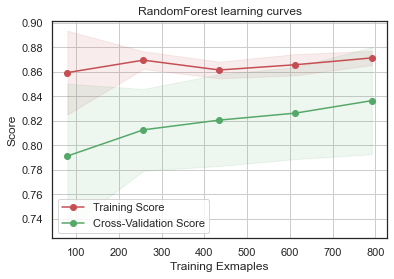

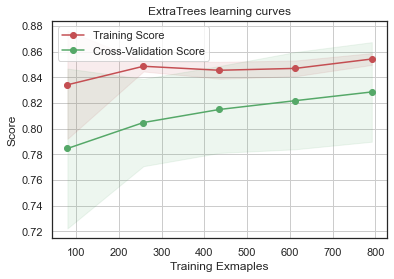

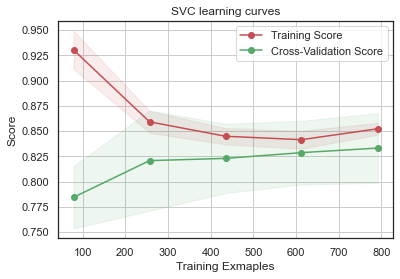

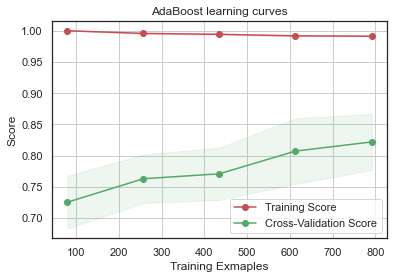

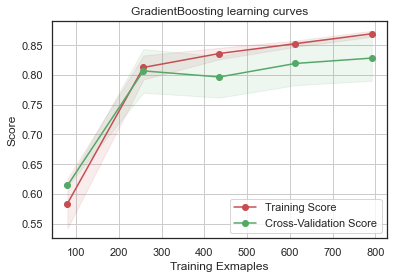

In [115]:
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Exmaples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,
                     train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std,
                     alpha=0.1, color='r')
    plt.fill_between(train_sizes,
                     test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std,
                     alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RandomForest learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', x_train, y_train, cv=kfold)

GradientBoost와 Adaboost 분류기는 과적합되는 경향이 있습니다. 증가하는 교차 검증 곡선에 따라 해당 분류기들은 더 많은 트레이닝 예제들로 성능이 좋아질 수 있습니다.  

SVC, ExtraTrees 분류기는 traing score 곡선과 cross-validation score 곡선이 밀접하기 때문에 예측을 보다 잘 일반화시키는 것으로 보입니다.

##### 6-1-4. 트리 기반 분류기의 변수 중요도
승객의 생존 예측에 대해 더욱 유의미한 feature를 보기 위해 4개의 트리 기반 분류기의 변수 중요도를 확인해보겠습니다.

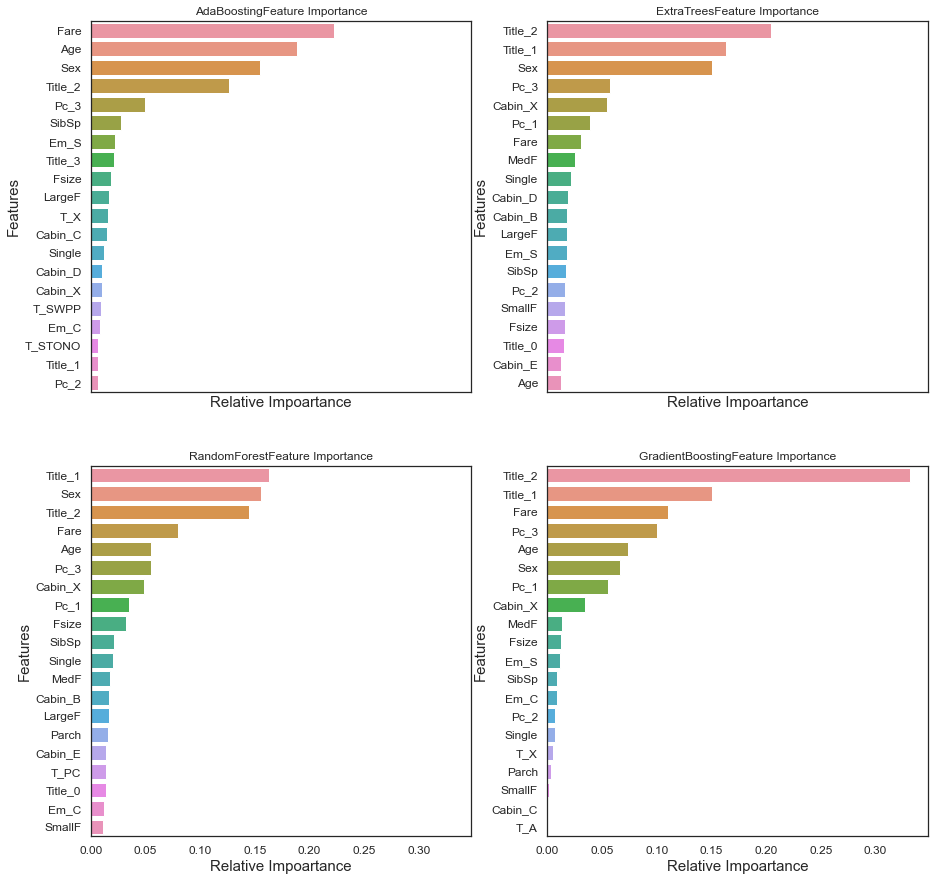

In [125]:
f, ax = plt.subplots(2, 2, sharex='all', figsize=(15, 15))
names_classifiers = [
    ('AdaBoosting', ada_best),
    ('ExtraTrees', ExtC_best),
    ('RandomForest', RFC_best),
    ('GradientBoosting', GBC_best)
]

nclassifier = 0
for row in range(2):
    for col in range(2):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(classifier.feature_importances_[indices], x_train.columns[indices][:40], orient='h', ax=ax[row, col])
        g.set_xlabel('Relative Impoartance', fontsize=15)
        g.set_ylabel('Features', fontsize=15)
        g.tick_params(labelsize=12)
        g.set_title(name + 'Feature Importance')
        nclassifier += 1

네 개의 분류기들은 상대적인 중요도에 따라 각자 다른 최상위 변수를 가지고 있으며, 이것은 같은 feature들 근거한 예측 결과가 아니라는 것을 의미합니다. 
* Pc_1, Pc_2, Pc_3, Fare은 승객들의 사회적 지위를 나타냅니다.
* Sex, Title_2, Title_3는 성별을 나타냅니다.
* Age, Title_1은 승객의 나이를 나타냅니다.
* Fsize, LarghF, MedF, Single은 승객의 가족 규모를 나타냅니다.  

네 개의 분류기에 대한 변수 중요도를 보면, 생존을 예측하는 데는 나이, 성별, 가족규모, 그리고 사회적 지위가 배 안의 위치보다 훨씬 관련 있습니다.

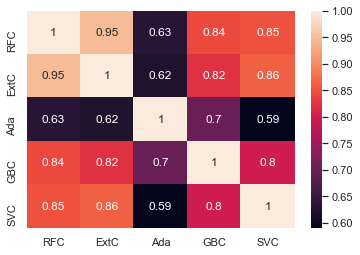

In [130]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

# 분류기의 예측 결과 조합
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC,test_Survived_AdaC,
                              test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

Adaboost를 제외한 나머지 분류기의 결과는 비슷해 보입니다. 5개의 분류기의 결과 간 차이는 vote 앙상블을 고려하기에는 충분합니다.

#### 6-2. 앙상블 모델링

##### 6-2-1. 모델 결합
위에서 본 5개의 분류기의 예측을 조합하기 위해 voting 분류기를 사용할 것입니다.  

각 투표의 확률을 고려하여 voting 파라미터에 'soft'를 사용하는 것을 선호합니다.

In [135]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
                                      ('extc', ExtC_best),
                                      ('svc', SVMC_best),
                                      ('adac', ada_best),
                                      ('gbc', GBC_best)],
                          voting='soft', n_jobs=4)
votingC = votingC.fit(x_train, y_train)

#### 6-3. 예측

##### 6-3-1. 예측 및 결과 제출

In [136]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
result = pd.concat([IDtest, test_Survived], axis=1)
result.to_csv('../data/titanic_3__submition.csv', index=False)

## Titnaic Top 4% with ensemble modeling

**✏ 필사 2회** 

### 목차
**1. Intro**  
**2. Load and check data**  
ㅤ2-1. 데이터 로딩  
ㅤ2-2. 이상값 탐지  
ㅤ2-3. 트레이닝 셋과 테스트 셋 결합  
ㅤ2-4. 결측값 확인  

**3. Feature analysis**  
ㅤ3-1. 숫자형 변수  
ㅤ3-2. 범주형 변수  

**4. Filling missing Values**  
ㅤ4-1. Age  

**5. Feature engineering**  
ㅤ5-1. Name/Title  
ㅤ5-2. Family Size  
ㅤ5-3. Cabin  
ㅤ5-4. Ticket  

**6. Modeling**  
ㅤ6-1. 간단한 모델링  
ㅤㅤㅤ6-1-1. 교차 검증 모델  
ㅤㅤㅤ6-1-2. 최적 모델을 위한 하이퍼 파라미터 튜닝  
ㅤㅤㅤ6-1-3. 학습 곡선  
ㅤㅤㅤ6-1-4. 트리 기반 분류기의 변수 중요도  
ㅤ6-2. 앙상블 모델링  
ㅤㅤㅤ6-2-1. 모델 결합  
ㅤ6-3. 예측  
ㅤㅤㅤ6-3-1. 예측 및 결과 제출

### 1. Introduction
몇 가지 feature 분석을 보인 뒤 feature engineering에 초점을 맞출 것입니다. 마지막 파트에서는 voting 방법을 사용하여 타이타닉의 생존여부를 모델링하고 예측하는 것을 다룰 예정입니다.  

이 노트북은 크게 세 가지 파트로 나뉩니다.  
* Feature analysis
* Feature engineering
* Modeling

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

### 2. Load and check data

#### 2-1. 데이터 로딩

In [140]:
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')
IDtest = test['PassengerId']

#### 2-2. 이상값 탐지

In [141]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1-outlier_step)|(df[col] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

In [142]:
outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

이상값들은 예측에 큰 영향을 주기 때문에 이들을 관리하기 위해 인덱스 리스트를 만들었습니다.  

이상값 검출을 위해 Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값들의 1분위수와 3분위수 사이에 구성된 범위를 정의(IQR)하였습니다.  

숫자형 변수들의 이상값을 탐지하고, 두 개 이상의 이상값을 갖는 행을 이상값이라고 판단했습니다.

In [143]:
train.iloc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상값이 탐지되었습니다. 28, 89, 342번 승객은 Fare 값이 크고, 나머지 7명은 SibSp 값이 매우 큽니다.

In [145]:
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

#### 2-3. 트레이닝 셋과 테스트 셋 결합

In [146]:
train_len = len(train)
dataset = pd.concat([train, test], axis=0).reset_index(drop=True)

이후에 feature engineering에서 범주형 변수로 바꾸는 과정에 동일한 수의 feature를 얻기 위해 트레이닝 셋과 테스트 셋을 병합했습니다.

#### 2-4. 결측값 확인

In [147]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin feature는 결측값 부분에서 매우 중요하며, Survived의 결측값은 테스트 셋의 결합에 의한 것입니다.

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [149]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [150]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [151]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [152]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### 3. Feature analysis

#### 3-1. 숫자형 변수

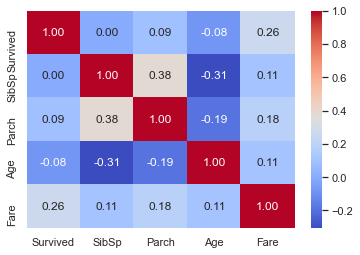

In [153]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Fare feature만이 생존 가능성과 유의미한 관계가 있는 것으로 보입니다. 그렇다고 다른 feature들이 쓸모없는 것은 아닙니다. 이 feature들의 하위 모집단이 생존과 관계가 있을 수 있습니다. 이것을 판단하기 위해, 해당 feature들을 더 자세히 분석해볼 필요가 있습니다.

##### SibSp

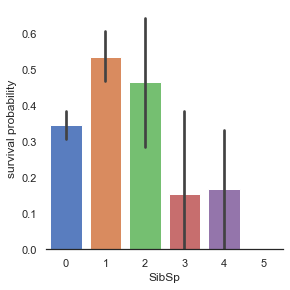

In [154]:
g = sns.factorplot('SibSp', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g.set_ylabels('survival probability')

승객들에게 형제자매나 배우자의 수가 많을수록 생존 가능성이 낮아지는 것처럼 보입니다. 혼자 탑승했거나 1~2명과 함께 탑승한 사람이 생존 가능성을 더 많이 가집니다.  

해당 관찰 내용 매우 흥미롭습니다. feature engineering 파트에서 이 카테고리들을 설명하는 새로운 feature를 고려해볼 수 있습니다.

##### Parch

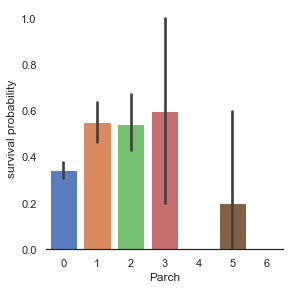

In [155]:
g = sns.factorplot('Parch', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

혼자 탑승하거나(Parch=0) 중간 규모 이상의 가족(Parch=3~6)보다 작은 규모의 가족들의 생존 가능성이 더 많습니다.  

부모/자식의 수가 3명 이상인 탑승자의 표준편차가 중요하므로 주의해야 합니다.

##### Age

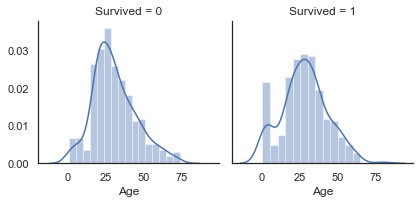

In [156]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

Age의 분포는 꼬리가 있는 분포이며, 가우시안 분포로 보입니다.  

생존한 경우와 생존하지 못한 경우의 연령 분포가 다르다는 것을 알 수 있습니다. Survived = 1의 그래프에서 젊은 승객들과 일치하는 피크가 있습니다. 또한 60-80세의 승객들의 생존류은 낮다는 사실 또한 알 수 있습니다.  

따라서 Age가 Survived와 관계가 없더라도 생존 가능성이 더 높거나 낮은 연령대가 있음을 알 수 있습니다.  

매우 어린 연령대의 승객들의 생존 가능성은 높습니다.

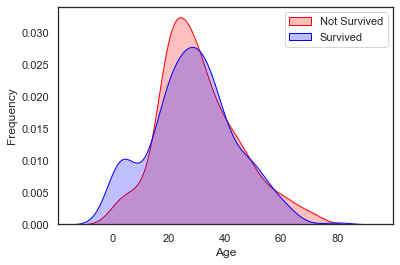

In [157]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1)*(train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 밀도 함수를 겹쳐서 살펴모녀 0~5세 영유아 나이대에 피크가 있음을 명확하게 확인할 수 있습니다.

##### Fare

In [158]:
dataset['Fare'].isnull().sum()

1

In [160]:
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

결측값이 하나밖에 없으므로 예측에 영향을 미치지 않도록 중간값으로 대체했습니다.

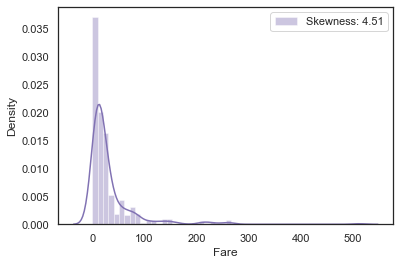

In [161]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

Fare의 분포는 매우 비대칭입니다. 비대칭도를 줄이기 위해 log 함수를 취해주는 것이 좋습니다.

In [162]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

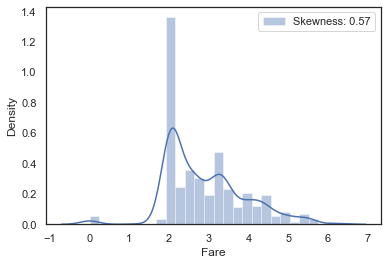

In [163]:
g = sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

#### 3-2. 범주형 변수

##### Sex

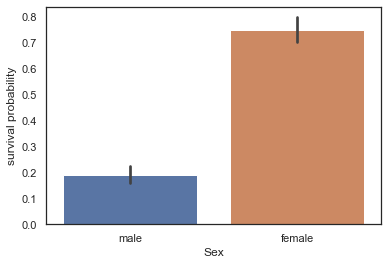

In [165]:
g = sns.barplot('Sex', 'Survived', data=train)
g = g.set_ylabel('survival probability')

In [166]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


##### Pclass

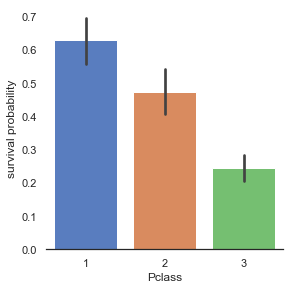

In [169]:
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

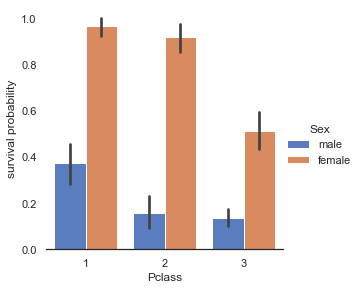

In [170]:
g = sns.factorplot('Pclass', 'Survived', hue='Sex', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

생존률은 세 클래스에서 같지 않습니다. 1등석 승객들은 2, 3등석보다 생존 가능성이 더 많았습니다. 이러한 경향은 남녀 승객을 함께 볼 때 유효합니다.

##### Embarked

In [171]:
dataset['Embarked'].isnull().sum()

2

In [172]:
dataset['Embarked'].fillna('S', inplace=True)

결측값 두 개는 가장 많은 값인 'S'로 대체합니다.

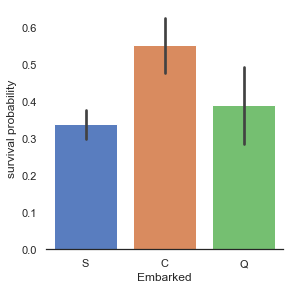

In [173]:
g = sns.factorplot('Embarked', 'Survived', data=train, kind='bar', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

C (Cherbourg) 항구에서 온 승객들의 생존률이 높습니다. 여기서 1등석 승객의 비율이 S (Southampton)와 Q (Queenstown)보다 Cherbourg에서 더 높을 것이라는 가설을 세워보겠습니다.  

Pclass의 분포와 Embarked를 비교해봅시다.

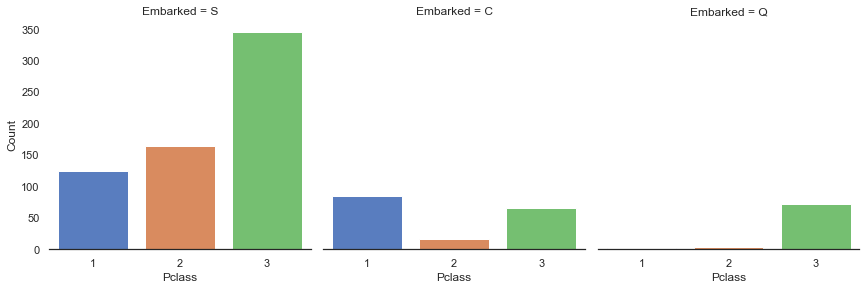

In [174]:
g = sns.factorplot('Pclass', col='Embarked', data=train, kind='count', size=4, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

3등석은 Southampton과 Queenstown에서 탑승한 승객이 많은 반면, Cherbourg 승객들은 대부분 생존률이 높은 1등석입니다.  

1등석의 생존률이 왜 높을까요? 1등석 승객들은 대피하는 동안 우선 순위였다고 가정해봅니다.

### 4. Filling missing Values

#### 4-1. Age
위에서 봤듯이 dataset의 Age 컬럼에는 256개의 결측값이 존재합니다. 어린이와 같이 생존률이 높은 하위집단이 존재하므로 Age feature는 유지하고, 결측값을 채우는 것이 더 좋습니다.  

이 문제를 해결하기 위해 Sex, Parch, Pclass, SipSp와 같은 관련있는 feature들을 살펴보겠습니다.

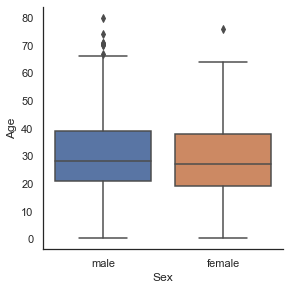

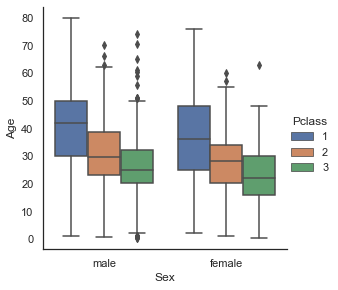

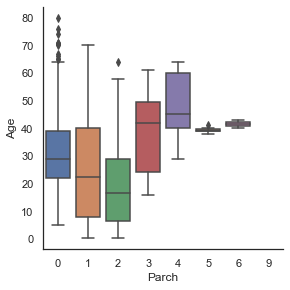

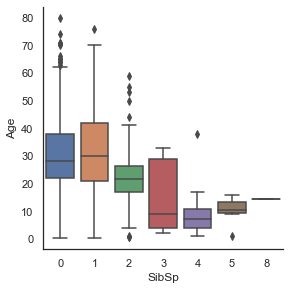

In [176]:
g = sns.factorplot('Sex', 'Age', data=dataset, kind='box', size=4)
g = sns.factorplot('Sex', 'Age', hue='Pclass', data=dataset, kind='box', size=4)
g = sns.factorplot('Parch', 'Age', data=dataset, kind='box', size=4)
g = sns.factorplot('SibSp', 'Age', data=dataset, kind='box', size=4)

남성과 여성 하위집단에 대해 연령 분포는 비슷해보이므로 Sex는 Age를 예측하는데 유의한 정보는 아닙니다.  

그러나 Pclass가 높아질수록 나이도 많아집니다.  

게다가 부모/자식의 수가 많을수록 나이가 많고, 형제자매/배우자의 수가 많을수록 나이가 적습니다.

In [177]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

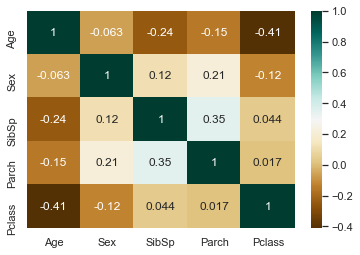

In [178]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), annot=True, cmap='BrBG')

Age는 Sex와는 관계가 없고, Pclass, Parch, SibSp와는 음의 상관관계를 가집니다. 따라서 Age의 결측값을 채우기 위해 SibSp, Parch, Pclass를 사용해봅시다. Pclass, Parch, SibSp에 따라 유사한 행의 중간값으로 결측값을 대체해보겠습니다.

In [183]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][(dataset['SibSp'] == dataset.iloc[i]['SibSp'])&
                              (dataset['Parch'] == dataset.iloc[i]['Parch'])&
                              (dataset['Pclass'] == dataset.iloc[i]['Pclass'])].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

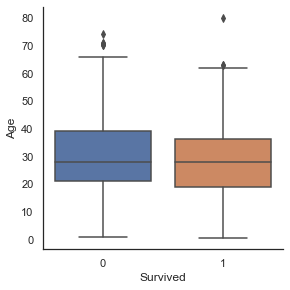

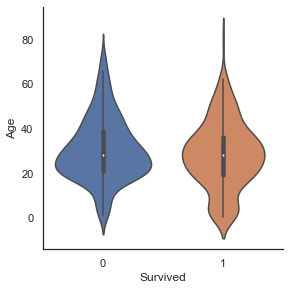

In [184]:
g = sns.factorplot('Survived', 'Age', data=train, kind='box', size=4)
g = sns.factorplot('Survived', 'Age', data=train, kind='violin', size=4)

생존한 하위집단과 생존하지 못한 하위집단의 Age에 대한 중간값은 차이가 없습니다.  

그러나 생존한 승객에 대한 violin plot을 보면, 매우 어린 승객들의 생존률이 높은 것을 다시 확인할 수 있습니다.

### 5. Feature Engineering

#### 5-1. Name/Title

In [185]:
dataset['Name'].head(3)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
Name: Name, dtype: object

Name feature는 승객의 title을 포함하고 있습니다. 대피 과정에서 승객의 title이 영향이 있을 수 있기 때문에, 해당 부분을 고려해보겠습니다.

In [191]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = dataset_title
dataset['Title'].head(3)

0      Mr
1     Mrs
2    Miss
Name: Title, dtype: object

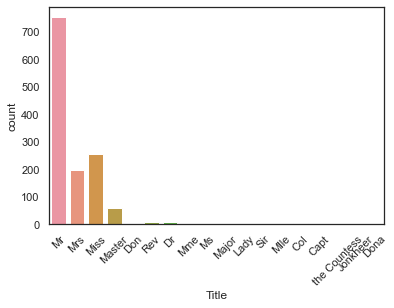

In [192]:
g = sns.countplot('Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

17가지의 title이 있으며, 대부분 수가 적으므로 크게 4개로 묶을 수 있습니다.

In [193]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms':1, 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

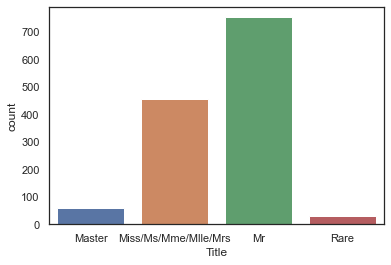

In [194]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

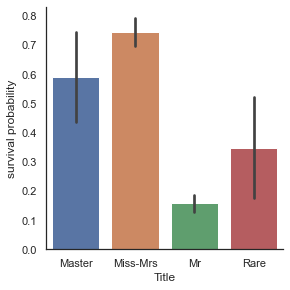

In [195]:
g = sns.factorplot('Title', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"여성과 아이 먼저"  
희귀한 title을 가진 승객의 생존 가능성이 높다는 점이 흥미롭습니다.

In [196]:
dataset.drop('Name', axis=1, inplace=True)

#### 5-2 Fsize (Family Size)
대가족은 대피 과정에서 형제자매/부모를 찾느라 대피하기에 더 어렵다고 짐작할 수 있습니다. 그래서 SibSp와 Parch, 자기 자신을 더한 Fsize (Family Size) feature을 만들어 볼 수 있습니다.

In [197]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

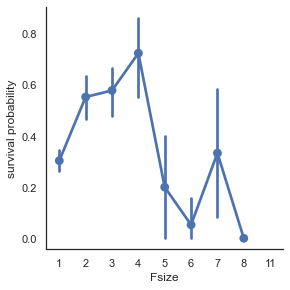

In [198]:
g = sns.factorplot('Fsize', 'Survived', data=dataset, size=4)
g = g.set_ylabels('survival probability')

가족 규모 또한 중요한 역할로 보이고, 대가족의 생존 가능성이 가장 낮습니다.  

가족 규모 또한 4개의 범주로 나눠보겠습니다.

In [199]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

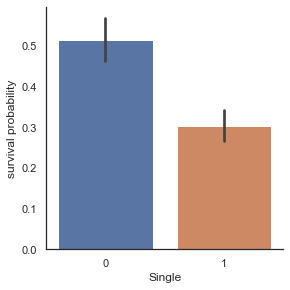

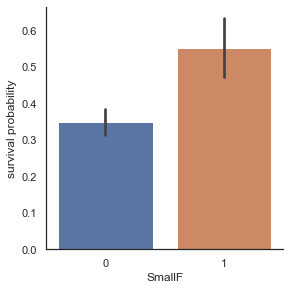

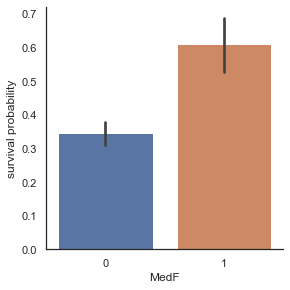

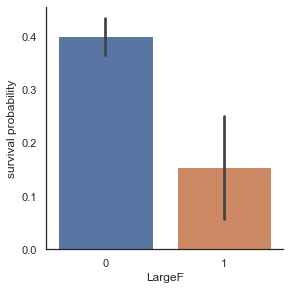

In [200]:
g = sns.factorplot('Single', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

g = sns.factorplot('SmallF', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

g = sns.factorplot('MedF', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

g = sns.factorplot('LargeF', 'Survived', data=dataset, kind='bar', size=4)
g = g.set_ylabels('survival probability')

factor plot을 통해 혼자 탑승했거나 대규모 가족보다 소규모, 중간규모의 가족에게 생존 기회가 더 많았음을 확인할 수 있습니다.

In [201]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [202]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [203]:
len(dataset.columns)

22

이제 22개의 feature가 있습니다.

#### 5-3. Cabin

In [204]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [205]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [206]:
dataset['Cabin'].isnull().sum()

1007

Cabin feature는 292개의 값과 1007개의 결측값이 있습니다. 객실이 없는 승객들의 경우 객실 번호 대신 결측값을 입력하는 것으로 알고 있습니다.

In [207]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [208]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

In [209]:
dataset['Cabin'].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

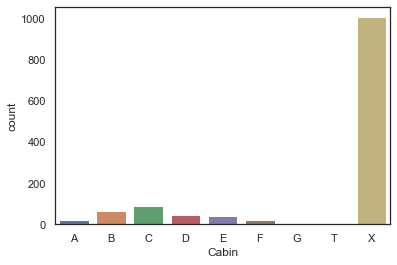

In [210]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

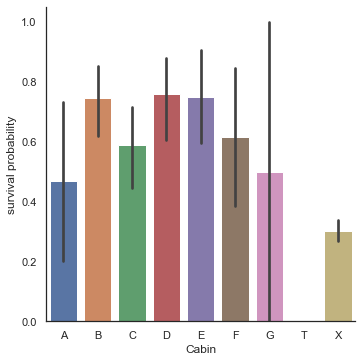

In [211]:
g = sns.factorplot('Cabin', 'Survived', data=dataset, kind='bar', order=['A', 'B', 'C','D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('survival probability')

객실을 가진 승객이 많지 않기 때문에, 생존 가능성은 중요한 표준 편차를 가집니다. 객실 간에는 생존 가능성을 구별할 수 없지만 객실이 있는 승객이 없는 승객보다 생존 가능성이 더 높습니다. 특히 B, C, D, E, F 객실은 더욱 그렇습니다.

In [212]:
dataset = pd.get_dummies(dataset, columns=['Cabin'])

In [213]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

In [214]:
len(dataset.columns)

30

#### 5-4. Ticket

In [215]:
dataset['Ticket'].head(3)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
Name: Ticket, dtype: object

앞부분에 같은 접두사가 붙은 티켓은 같은 공간에 있는 객실을 예약했음을 의미합니다. 같은 접두사를 가진 티켓은 클래스와 생존률이 비슷할 것입니다.  

Ticket feature의 접두사만 사용하겠습니다.

In [216]:
Ticket = []
for i in list(dataset['Ticket']):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head(3)

0        A5
1        PC
2    STONO2
Name: Ticket, dtype: object

In [217]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [218]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [219]:
dataset.drop('PassengerId', axis=1, inplace=True)

In [220]:
dataset.head(3)

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1


### 6. Modeling

In [221]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop('Survived', axis=1, inplace=True)

In [222]:
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
x_train = train.drop('Survived', axis=1)

#### 6-1. 간단한 모델링

##### 6-1-1. 교차 검증 모델  
stratified Kfold 교차 검증을 통해 10개의 유명한 분류기에 대해 각각의 평균 정확도를 비교해봅시다.  

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron (neural network) (다층신경망)
* KNN
* Logistic Regression (로지스틱회귀분석)
* Linear Discriminant Analysis (선형판별분석)

In [223]:
kfold = StratifiedKFold(n_splits=10)

In [224]:
classifiers = [
    SVC(random_state=123),
    DecisionTreeClassifier(random_state=123),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=123), random_state=123, learning_rate=0.1),
    RandomForestClassifier(random_state=123),
    ExtraTreesClassifier(random_state=123),
    GradientBoostingClassifier(random_state=123),
    MLPClassifier(random_state=123),
    KNeighborsClassifier(),
    LogisticRegression(random_state=123),
    LinearDiscriminantAnalysis()
]

In [225]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, x_train, y_train, scoring='accuracy', cv=kfold, n_jobs=4))

In [226]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [227]:
cv_res = pd.DataFrame({
    'CrossValMeans':cv_means,
    'CrossValerrors':cv_std,
    'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron',
                'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']
})

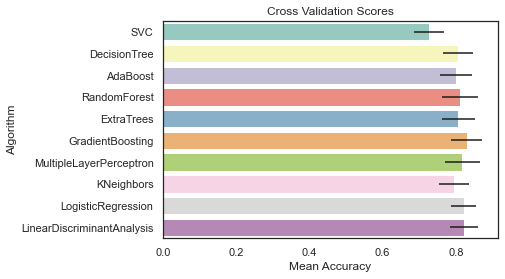

In [228]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

앙상블 모델에는 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 사용해보려 합니다.

##### 6-1-2. 최적 모델을 위한 하이퍼 파라미터 튜닝
AdaBoost, ExtraTrees, RandomForest, GradientBoosting, SVC 분류기에 대한 격자 탐색 최적화를 수행했습니다.  

저는 cpu가 4개이기 때문에 n_jobs를 4로 설정하였습니다. n_jobs 값이 크면 연산 속도가 매우 줄어듭니다. 그러나 다음 과정은 매우 오래 걸릴 것입니다. 4개의 cpu로도 15분이 소요되었습니다.  

*verbose:  
0 = silent  
1 = progress bar  
2 = one line per epoch  

In [229]:
adaDTC = AdaBoostClassifier(DecisionTreeClassifier(), random_state=5)
ada_param_grid = {
    'base_estimator__criterion':['gini', 'entropy'],
    'base_estimator__splitter':['best', 'random'],
    'n_estimators':[1, 2],
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(x_train, y_train)
ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_score_)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.0s


0.8218590398365679


[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    2.7s finished


In [230]:
ExtC = ExtraTreesClassifier()
ex_param_grid = {
    'max_depth':[None],
    'max_features':[1, 3, 10],
    'min_samples_split':[2, 3, 10],
    'min_samples_leaf':[1, 3, 10],
    'bootstrap':[False],
    'n_estimators':[100, 300],
    'criterion':['gini']
}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy',n_jobs=4, verbose=1)
gsExtC.fit(x_train, y_train)
ExtC_best = gsExtC.best_estimator_
print(gsExtC.best_score_)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   38.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   46.0s finished


0.8320224719101124


In [231]:
RFC = RandomForestClassifier()
rf_param_grid = {
    'max_depth':[None],
    'max_features':[1, 3, 10],
    'min_samples_split':[2, 3, 10],
    'min_samples_leaf':[1, 3, 10],
    'bootstrap':[False],
    'n_estimators':[100, 300],
    'criterion':['gini']
}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(x_train, y_train)
RFC_best = gsRFC.best_estimator_
print(gsRFC.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.0min finished


0.8354187946884576


In [232]:
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss':['deviance'],
    'n_estimators':[100, 200, 300],
    'learning_rate':[0.1, 0.05, 0.01],
    'max_depth':[4, 8],
    'min_samples_leaf':[100, 150],
    'max_features':[0.3, 0.1]
}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(x_train, y_train)
GBC_best = gsGBC.best_estimator_
print(gsGBC.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   34.8s finished


0.8365551583248212


In [233]:
SVMC = SVC(probability=True)
svc_param_grid = {
    'kernel':['rbf'],
    'gamma':[0.001, 0.01, 0.1, 1],
    'C':[1, 10, 50, 100, 200, 300, 1000]
}

gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(x_train, y_train)
SVMC_best = gsSVMC.best_estimator_
print(gsSVMC.best_score_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   30.1s finished


0.8331332992849847


##### 6-1-3. 학습 곡선
학습 곡선은 트레이닝 셋에 대한 과적합과 트레이닝 크기가 정확도에 미치는 영향을 확인하기에 좋습니다.

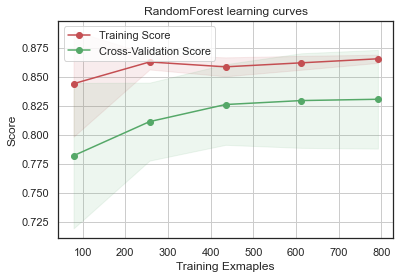

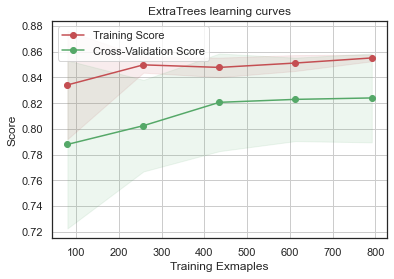

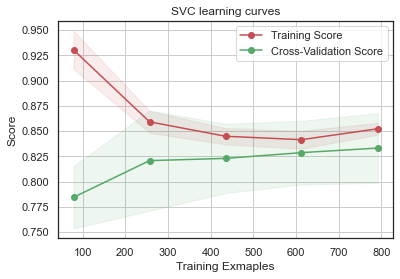

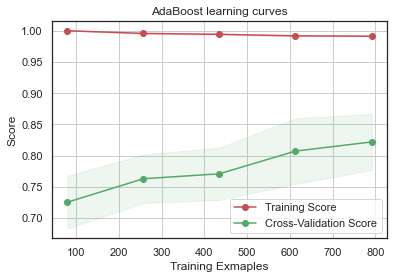

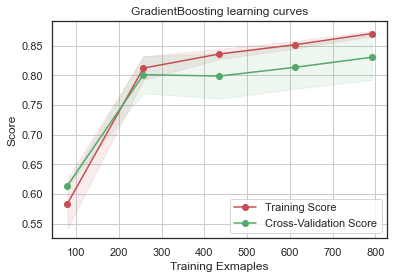

In [234]:
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Exmaples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,
                     train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std,
                     alpha=0.1, color='r')
    plt.fill_between(train_sizes,
                     test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std,
                     alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RandomForest learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', x_train, y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', x_train, y_train, cv=kfold)

GradientBoost와 Adaboost 분류기는 과적합되는 경향이 있습니다. 증가하는 교차 검증 곡선에 따라 해당 분류기들은 더 많은 트레이닝 예제들로 성능이 좋아질 수 있습니다.  

SVC, ExtraTrees 분류기는 traing score 곡선과 cross-validation score 곡선이 밀접하기 때문에 예측을 보다 잘 일반화시키는 것으로 보입니다.

##### 6-1-4. 트리 기반 분류기의 변수 중요도
승객의 생존 예측에 대해 더욱 유의미한 feature를 보기 위해 4개의 트리 기반 분류기의 변수 중요도를 확인해보겠습니다.

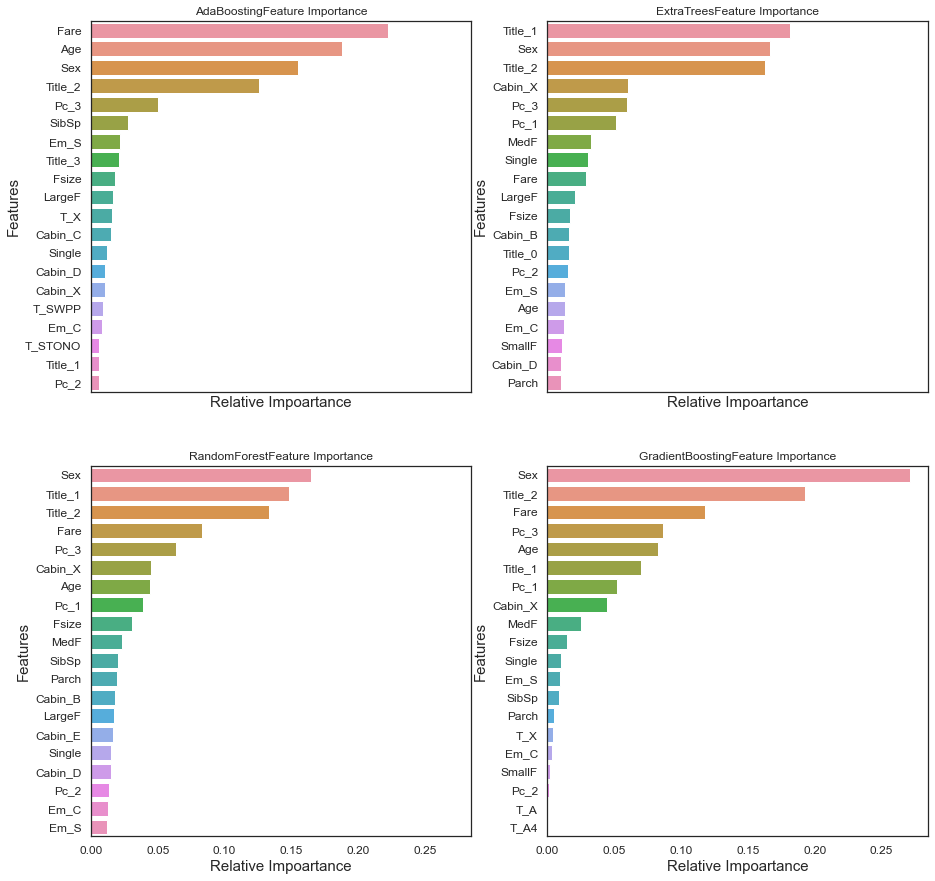

In [235]:
f, ax = plt.subplots(2, 2, sharex='all', figsize=(15, 15))
names_classifiers = [
    ('AdaBoosting', ada_best),
    ('ExtraTrees', ExtC_best),
    ('RandomForest', RFC_best),
    ('GradientBoosting', GBC_best)
]

nclassifier = 0
for row in range(2):
    for col in range(2):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(classifier.feature_importances_[indices], x_train.columns[indices][:40], orient='h', ax=ax[row, col])
        g.set_xlabel('Relative Impoartance', fontsize=15)
        g.set_ylabel('Features', fontsize=15)
        g.tick_params(labelsize=12)
        g.set_title(name + 'Feature Importance')
        nclassifier += 1

네 개의 분류기들은 상대적인 중요도에 따라 각자 다른 최상위 변수를 가지고 있으며, 이것은 같은 feature들 근거한 예측 결과가 아니라는 것을 의미합니다. 
* Pc_1, Pc_2, Pc_3, Fare은 승객들의 사회적 지위를 나타냅니다.
* Sex, Title_2, Title_3는 성별을 나타냅니다.
* Age, Title_1은 승객의 나이를 나타냅니다.
* Fsize, LarghF, MedF, Single은 승객의 가족 규모를 나타냅니다.  

네 개의 분류기에 대한 변수 중요도를 보면, 생존을 예측하는 데는 나이, 성별, 가족규모, 그리고 사회적 지위가 배 안의 위치보다 훨씬 관련 있습니다.

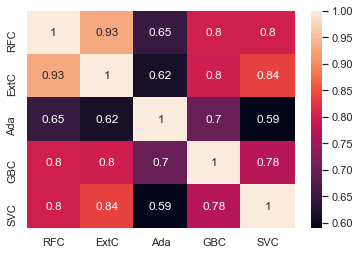

In [236]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC,test_Survived_AdaC,
                              test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

Adaboost를 제외한 나머지 분류기의 결과는 비슷해 보입니다. 5개의 분류기의 결과 간 차이는 vote 앙상블을 고려하기에는 충분합니다.

#### 6-2. 앙상블 모델링

##### 6-2-1. 모델 결합
위에서 본 5개의 분류기의 예측을 조합하기 위해 voting 분류기를 사용할 것입니다.  

각 투표의 확률을 고려하여 voting 파라미터에 'soft'를 사용하는 것을 선호합니다.

In [237]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
                                      ('extc', ExtC_best),
                                      ('svc', SVMC_best),
                                      ('adac', ada_best),
                                      ('gbc', GBC_best)],
                          voting='soft', n_jobs=4)
votingC = votingC.fit(x_train, y_train)

#### 6-3. 예측

##### 6-3-1. 예측 및 결과 제출

In [238]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
result = pd.concat([IDtest, test_Survived], axis=1)
result.to_csv('../data/titanic_3__submition.csv', index=False)